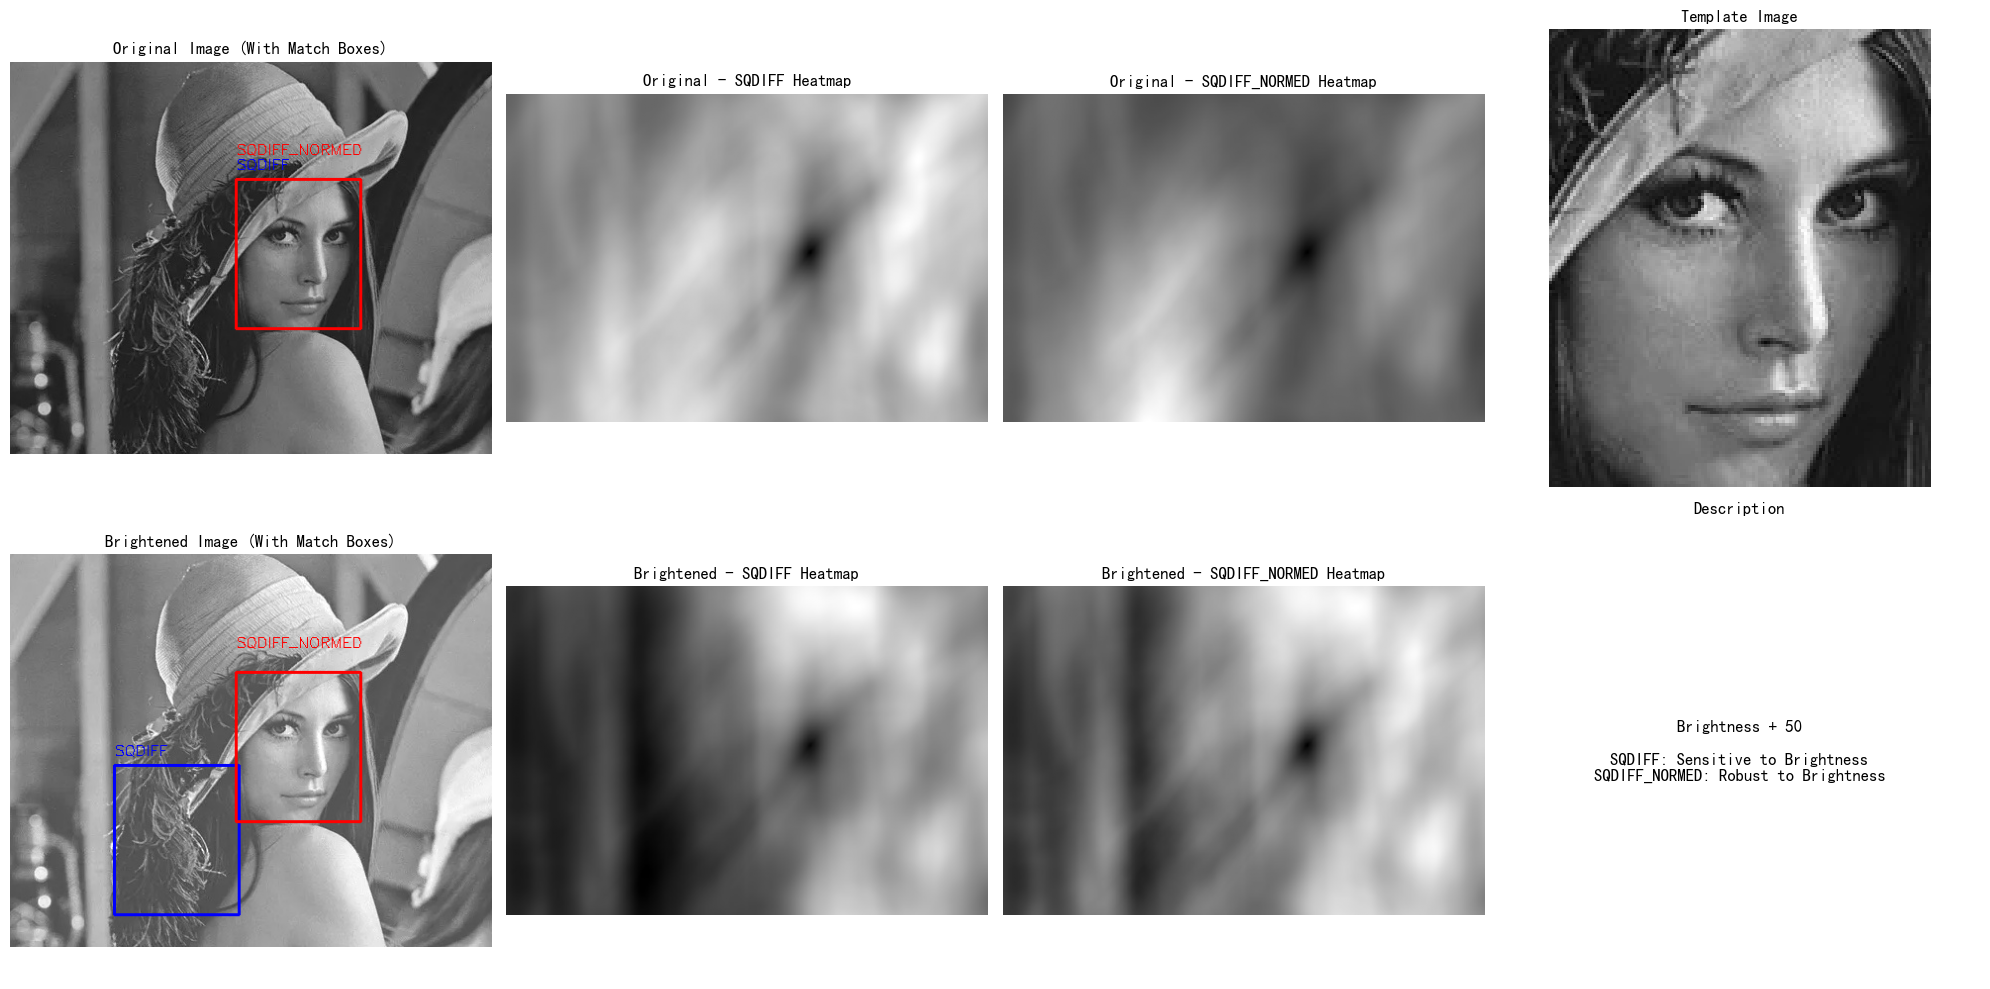

【原图匹配结果】
SQDIFF 最佳匹配位置：(228, 119)
SQDIFF 最小差异值：89680.000000
SQDIFF_NORMED 最佳匹配位置：(228, 119)
SQDIFF_NORMED 最小差异值（[0,1]）：0.000398

【加亮度图匹配结果（亮度+50）】
SQDIFF 最佳匹配位置：(105, 213)
SQDIFF 最小差异值：43063264.000000
SQDIFF_NORMED 最佳匹配位置：(228, 119)
SQDIFF_NORMED 最小差异值（[0,1]）：0.147494


In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取图像和模板
# 读取目标图像（大图），以灰度模式读取（简化计算，彩色图可转为3通道分别计算）
target_img = cv2.imread('target.jpg', 0)
# 读取模板图像（小图），灰度模式
template_img = cv2.imread('template.jpg', 0)

# 校验图像是否读取成功
if target_img is None or template_img is None:
    raise ValueError("图像读取失败，请检查文件路径或文件格式是否正确！")

# 2. 获取模板尺寸
template_h, template_w = template_img.shape[:2]
target_h, target_w = target_img.shape[:2]

# 校验模板尺寸是否小于目标图像
if template_h > target_h or template_w > target_w:
    raise ValueError("模板尺寸不能大于目标图像尺寸！")

# 3. 生成加亮度后的目标图像（整体亮度+50，模拟光照变亮场景，避免溢出）
# 转换为float32防止uint8溢出，再裁剪到0-255区间，最后转回uint8
target_img_bright = target_img.astype(np.float32) + 50
target_img_bright = np.clip(target_img_bright, 0, 255).astype(np.uint8)

# 4. 执行4种匹配计算（原图2种 + 加亮度图2种）
# 4.1 原图匹配
# 原图 - 基础平方差匹配（SQDIFF）
result_sqdiff_original = cv2.matchTemplate(
    image=target_img,
    templ=template_img,
    method=cv2.TM_SQDIFF
)

# 原图 - 归一化平方差匹配（SQDIFF_NORMED）
result_sqdiff_normed_original = cv2.matchTemplate(
    image=target_img,
    templ=template_img,
    method=cv2.TM_SQDIFF_NORMED
)

# 4.2 加亮度图像匹配
# 加亮度图 - 基础平方差匹配（SQDIFF）
result_sqdiff_bright = cv2.matchTemplate(
    image=target_img_bright,
    templ=template_img,
    method=cv2.TM_SQDIFF
)

# 加亮度图 - 归一化平方差匹配（SQDIFF_NORMED）
result_sqdiff_normed_bright = cv2.matchTemplate(
    image=target_img_bright,
    templ=template_img,
    method=cv2.TM_SQDIFF_NORMED
)

# 5. 寻找所有最佳匹配位置（值越小，匹配度越高）
def get_best_match_loc(result):
    """提取匹配结果的最佳位置"""
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return min_loc, min_val

# 原图匹配结果
best_loc_sqdiff_ori, min_val_sqdiff_ori = get_best_match_loc(result_sqdiff_original)
best_loc_normed_ori, min_val_normed_ori = get_best_match_loc(result_sqdiff_normed_original)

# 加亮度图匹配结果
best_loc_sqdiff_bright, min_val_sqdiff_bright = get_best_match_loc(result_sqdiff_bright)
best_loc_normed_bright, min_val_normed_bright = get_best_match_loc(result_sqdiff_normed_bright)

# 6. 绘制匹配框（原图 + 加亮度图）
def draw_match_box(img_gray, best_loc_sqdiff, best_loc_normed, title_prefix):
    """
    绘制匹配框并返回彩色图像
    :param img_gray: 灰度图像
    :param best_loc_sqdiff: SQDIFF最佳位置
    :param best_loc_normed: SQDIFF_NORMED最佳位置
    :param title_prefix: 图像标题前缀
    :return: 带匹配框的彩色图像、图像标题
    """
    img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

    # 绘制SQDIFF匹配框（蓝色）
    tl_sqdiff = best_loc_sqdiff
    br_sqdiff = (tl_sqdiff[0] + template_w, tl_sqdiff[1] + template_h)
    cv2.rectangle(img_color, tl_sqdiff, br_sqdiff, (255, 0, 0), 2)
    cv2.putText(img_color, 'SQDIFF', (tl_sqdiff[0], tl_sqdiff[1]-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # 绘制SQDIFF_NORMED匹配框（红色）
    tl_normed = best_loc_normed
    br_normed = (tl_normed[0] + template_w, tl_normed[1] + template_h)
    cv2.rectangle(img_color, tl_normed, br_normed, (0, 0, 255), 2)
    cv2.putText(img_color, 'SQDIFF_NORMED', (tl_normed[0], tl_normed[1]-25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    return img_color, f'{title_prefix} (With Match Boxes)'

# 绘制原图和加亮度图的匹配框
img_ori_box, title_ori_box = draw_match_box(target_img, best_loc_sqdiff_ori, best_loc_normed_ori, 'Original Image')
img_bright_box, title_bright_box = draw_match_box(target_img_bright, best_loc_sqdiff_bright, best_loc_normed_bright, 'Brightened Image')

# 7. 可视化结果（2行4列，清晰对比）
plt.figure(figsize=(20, 10))

# 第一行：原图相关结果（原图+匹配框、SQDIFF热力图、SQDIFF_NORMED热力图、模板）
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(img_ori_box, cv2.COLOR_BGR2RGB))
plt.title(title_ori_box)
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(result_sqdiff_original, cmap='gray')
plt.title('Original - SQDIFF Heatmap')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(result_sqdiff_normed_original, cmap='gray')
plt.title('Original - SQDIFF_NORMED Heatmap')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(template_img, cmap='gray')
plt.title('Template Image')
plt.axis('off')

# 第二行：加亮度图相关结果（加亮度图+匹配框、SQDIFF热力图、SQDIFF_NORMED热力图、亮度说明）
plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(img_bright_box, cv2.COLOR_BGR2RGB))
plt.title(title_bright_box)
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(result_sqdiff_bright, cmap='gray')
plt.title('Brightened - SQDIFF Heatmap')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(result_sqdiff_normed_bright, cmap='gray')
plt.title('Brightened - SQDIFF_NORMED Heatmap')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.text(0.5, 0.5, 'Brightness + 50\n\nSQDIFF: Sensitive to Brightness\nSQDIFF_NORMED: Robust to Brightness',
         ha='center', va='center', fontsize=12, wrap=True)
plt.title('Description')
plt.axis('off')

plt.tight_layout()
plt.show()

# 8. 输出关键信息（清晰对比两组结果）
print("="*60)
print("【原图匹配结果】")
print("="*60)
print(f"SQDIFF 最佳匹配位置：{best_loc_sqdiff_ori}")
print(f"SQDIFF 最小差异值：{min_val_sqdiff_ori:.6f}")
print(f"SQDIFF_NORMED 最佳匹配位置：{best_loc_normed_ori}")
print(f"SQDIFF_NORMED 最小差异值（[0,1]）：{min_val_normed_ori:.6f}")
print("\n" + "="*60)
print("【加亮度图匹配结果（亮度+50）】")
print("="*60)
print(f"SQDIFF 最佳匹配位置：{best_loc_sqdiff_bright}")
print(f"SQDIFF 最小差异值：{min_val_sqdiff_bright:.6f}")
print(f"SQDIFF_NORMED 最佳匹配位置：{best_loc_normed_bright}")
print(f"SQDIFF_NORMED 最小差异值（[0,1]）：{min_val_normed_bright:.6f}")
print("="*60)

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [55]:
img = cv2.imread('target.jpg', 0)
tpl = cv2.imread('template.jpg', 0)

if img is None or tpl is None:
    raise ValueError("图像读取失败")

h, w = tpl.shape[:2]
img_h, img_w = img.shape[:2]

if h > img_h or w > img_w:
    raise ValueError("模板尺寸过大")

In [56]:
img_bright = img.astype(np.float32) + 50
img_bright = np.clip(img_bright, 0, 255).astype(np.uint8)

In [57]:
res_sqdiff = cv2.matchTemplate(img, tpl, cv2.TM_SQDIFF)
res_nsqdiff = cv2.matchTemplate(img, tpl, cv2.TM_SQDIFF_NORMED)
res_sqdiff_bright = cv2.matchTemplate(img_bright, tpl, cv2.TM_SQDIFF)
res_nsqdiff_bright = cv2.matchTemplate(img_bright, tpl, cv2.TM_SQDIFF_NORMED)

In [58]:
def get_best(res):
    return cv2.minMaxLoc(res)[2], cv2.minMaxLoc(res)[0]

loc_sq, val_sq = get_best(res_sqdiff)
loc_nsq, val_nsq = get_best(res_nsqdiff)
loc_sq_b, val_sq_b = get_best(res_sqdiff_bright)
loc_nsq_b, val_nsq_b = get_best(res_nsqdiff_bright)

In [59]:
def draw_box(gray, loc1, loc2, prefix):
    color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(color, loc1, (loc1[0]+w, loc1[1]+h), (255,0,0), 2)
    cv2.putText(color, '平方差', (loc1[0], loc1[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    cv2.rectangle(color, loc2, (loc2[0]+w, loc2[1]+h), (0,0,255), 2)
    cv2.putText(color, '归一化平方差', (loc2[0], loc2[1]-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    return color, f'{prefix}（含匹配框）'

img_box, title1 = draw_box(img, loc_sq, loc_nsq, '原始图像')
img_bright_box, title2 = draw_box(img_bright, loc_sq_b, loc_nsq_b, '增亮图像')

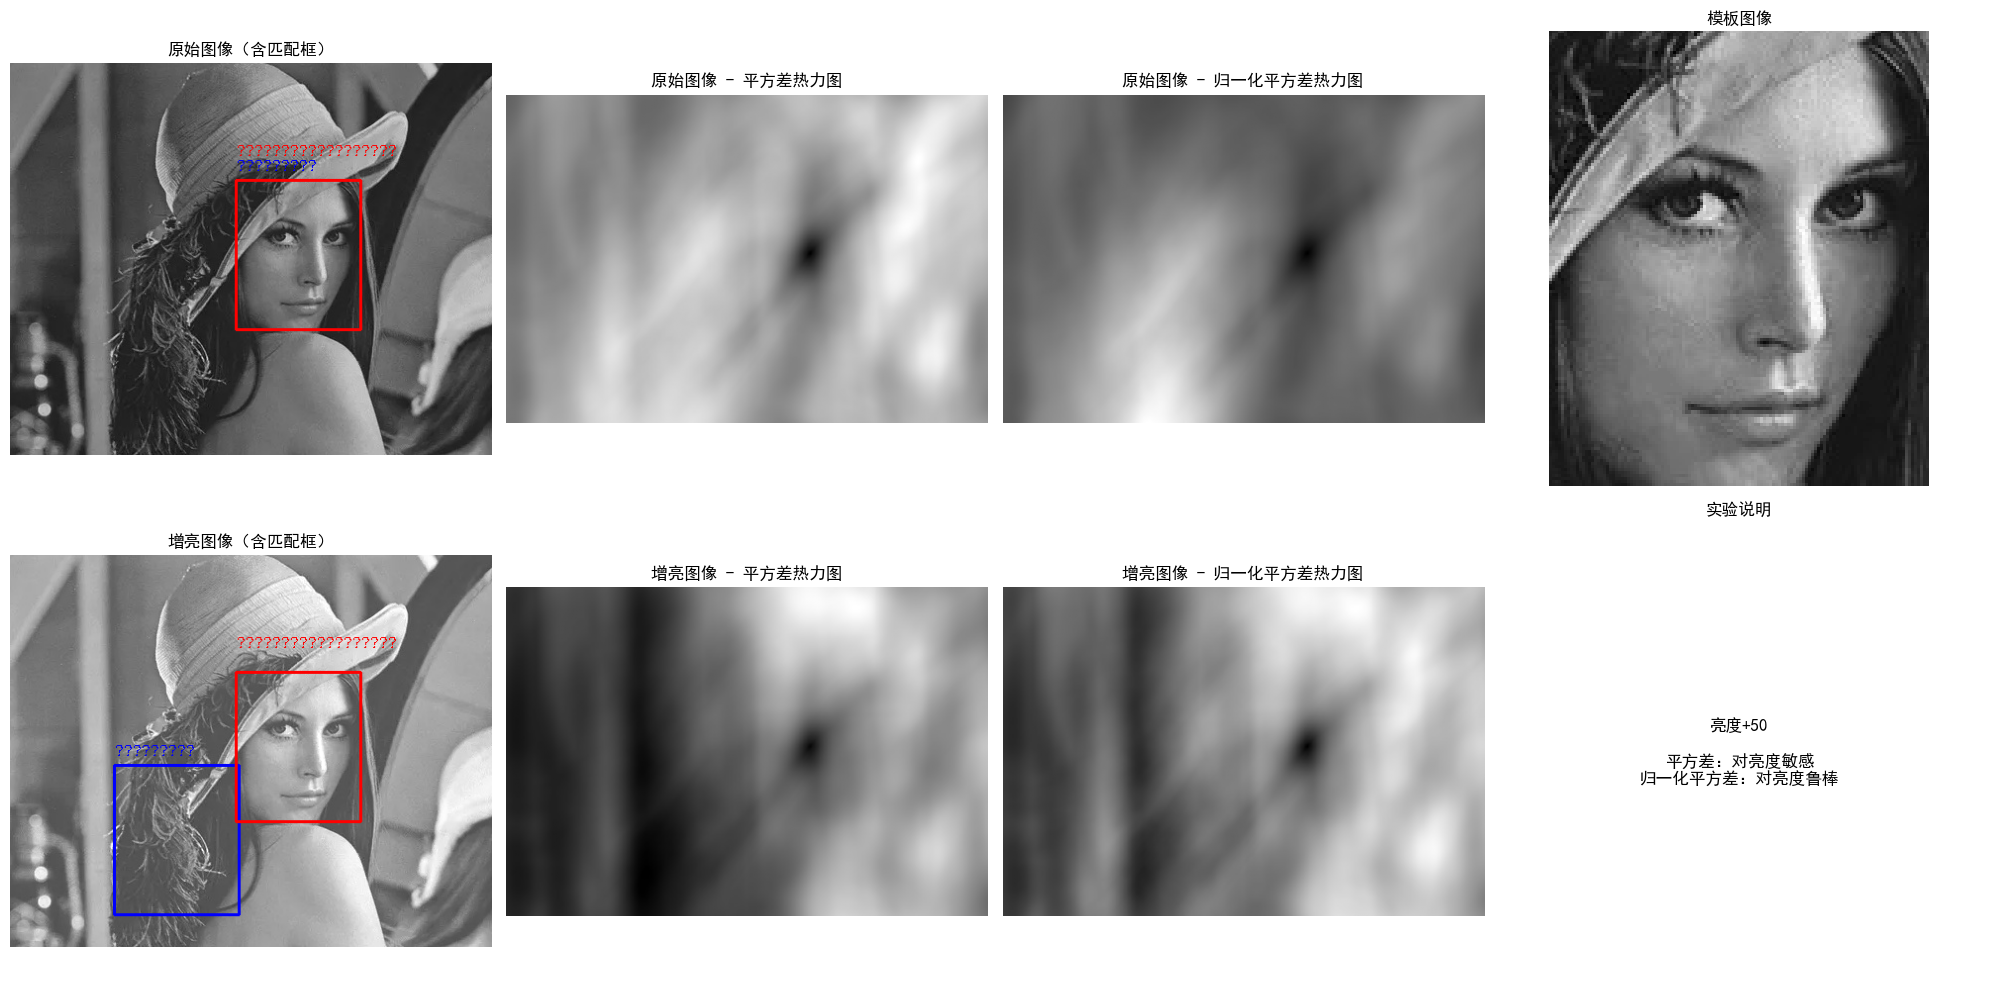

【原始图像匹配结果】
平方差 位置：(228, 119) | 最小差值：89680.000000
归一化平方差 位置：(228, 119) | 最小差值：0.000398
【增亮图像匹配结果】
平方差 位置：(105, 213) | 最小差值：43063264.000000
归一化平方差 位置：(228, 119) | 最小差值：0.147494


In [60]:
plt.figure(figsize=(20, 10))

plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
plt.title(title1)
plt.axis('off')

plt.subplot(2,4,2)
plt.imshow(res_sqdiff, cmap='gray')
plt.title('原始图像 - 平方差热力图')
plt.axis('off')

plt.subplot(2,4,3)
plt.imshow(res_nsqdiff, cmap='gray')
plt.title('原始图像 - 归一化平方差热力图')
plt.axis('off')

plt.subplot(2,4,4)
plt.imshow(tpl, cmap='gray')
plt.title('模板图像')
plt.axis('off')

plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(img_bright_box, cv2.COLOR_BGR2RGB))
plt.title(title2)
plt.axis('off')

plt.subplot(2,4,6)
plt.imshow(res_sqdiff_bright, cmap='gray')
plt.title('增亮图像 - 平方差热力图')
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(res_nsqdiff_bright, cmap='gray')
plt.title('增亮图像 - 归一化平方差热力图')
plt.axis('off')

plt.subplot(2,4,8)
plt.text(0.5,0.5,'亮度+50\n\n平方差：对亮度敏感\n归一化平方差：对亮度鲁棒',ha='center',va='center',fontsize=12)
plt.title('实验说明')
plt.axis('off')

plt.tight_layout()
plt.show()


print("【原始图像匹配结果】")

print(f"平方差 位置：{loc_sq} | 最小差值：{val_sq:.6f}")
print(f"归一化平方差 位置：{loc_nsq} | 最小差值：{val_nsq:.6f}")

print("【增亮图像匹配结果】")

print(f"平方差 位置：{loc_sq_b} | 最小差值：{val_sq_b:.6f}")
print(f"归一化平方差 位置：{loc_nsq_b} | 最小差值：{val_nsq_b:.6f}")


In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 中文显示配置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取图像与模板
img = cv2.imread('target.jpg', 0)
tpl = cv2.imread('template.jpg', 0)

if img is None or tpl is None:
    raise ValueError("图像读取失败，请检查文件路径！")

h, w = tpl.shape[:2]
img_h, img_w = img.shape[:2]

if h > img_h or w > img_w:
    raise ValueError("模板尺寸不能大于目标图像！")

In [62]:
# 2. 生成干扰图像（增亮+提高对比度）
img_bright = img.astype(np.float32) + 50
img_bright = np.clip(img_bright, 0, 255).astype(np.uint8)
img_contrast = cv2.convertScaleAbs(img, alpha=1.5, beta=0)

# 3. 执行6次相关性匹配（3张图 × 2种算法）
res_ccorr = cv2.matchTemplate(img, tpl, cv2.TM_CCORR)
res_ncc = cv2.matchTemplate(img, tpl, cv2.TM_CCORR_NORMED)
res_ccorr_bright = cv2.matchTemplate(img_bright, tpl, cv2.TM_CCORR)
res_ncc_bright = cv2.matchTemplate(img_bright, tpl, cv2.TM_CCORR_NORMED)
res_ccorr_contrast = cv2.matchTemplate(img_contrast, tpl, cv2.TM_CCORR)
res_ncc_contrast = cv2.matchTemplate(img_contrast, tpl, cv2.TM_CCORR_NORMED)

# 4. 获取最佳匹配位置（相关性类：值越大匹配度越高，取最大值位置）
def get_best_corr(res):
    max_loc = cv2.minMaxLoc(res)[3]
    max_val = cv2.minMaxLoc(res)[1]
    return max_loc, max_val

loc_ccorr, val_ccorr = get_best_corr(res_ccorr)
loc_ncc, val_ncc = get_best_corr(res_ncc)
loc_ccorr_bright, val_ccorr_bright = get_best_corr(res_ccorr_bright)
loc_ncc_bright, val_ncc_bright = get_best_corr(res_ncc_bright)
loc_ccorr_contrast, val_ccorr_contrast = get_best_corr(res_ccorr_contrast)
loc_ncc_contrast, val_ncc_contrast = get_best_corr(res_ncc_contrast)

In [63]:
# 5. 绘制匹配框（修正文字位置到框内底部，确保显示完整，不超出图像范围）
def draw_corr_box(gray, loc1, loc2, prefix):
    gray_copy = gray.copy()
    color = cv2.cvtColor(gray_copy, cv2.COLOR_GRAY2BGR)
    # 普通相关性（CCORR，蓝色框）- 文字放在框内底部，偏移5像素避免贴边
    cv2.rectangle(color, loc1, (loc1[0]+w, loc1[1]+h), (255,0,0), 2)
    cv2.putText(color, 'CCORR', (loc1[0]+5, loc1[1]+h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    # 归一化互相关（NCC，红色框）- 文字放在框内底部，偏移5像素避免贴边
    cv2.rectangle(color, loc2, (loc2[0]+w, loc2[1]+h), (0,0,255), 2)
    cv2.putText(color, 'NCC', (loc2[0]+5, loc2[1]+h-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    return color, f'{prefix}（含匹配框）'

# 生成3张带框图像
img_box, title1 = draw_corr_box(img, loc_ccorr, loc_ncc, '原始图像')
img_bright_box, title2 = draw_corr_box(img_bright, loc_ccorr_bright, loc_ncc_bright, '增亮图像')
img_contrast_box, title3 = draw_corr_box(img_contrast, loc_ccorr_contrast, loc_ncc_contrast, '高对比度图像')

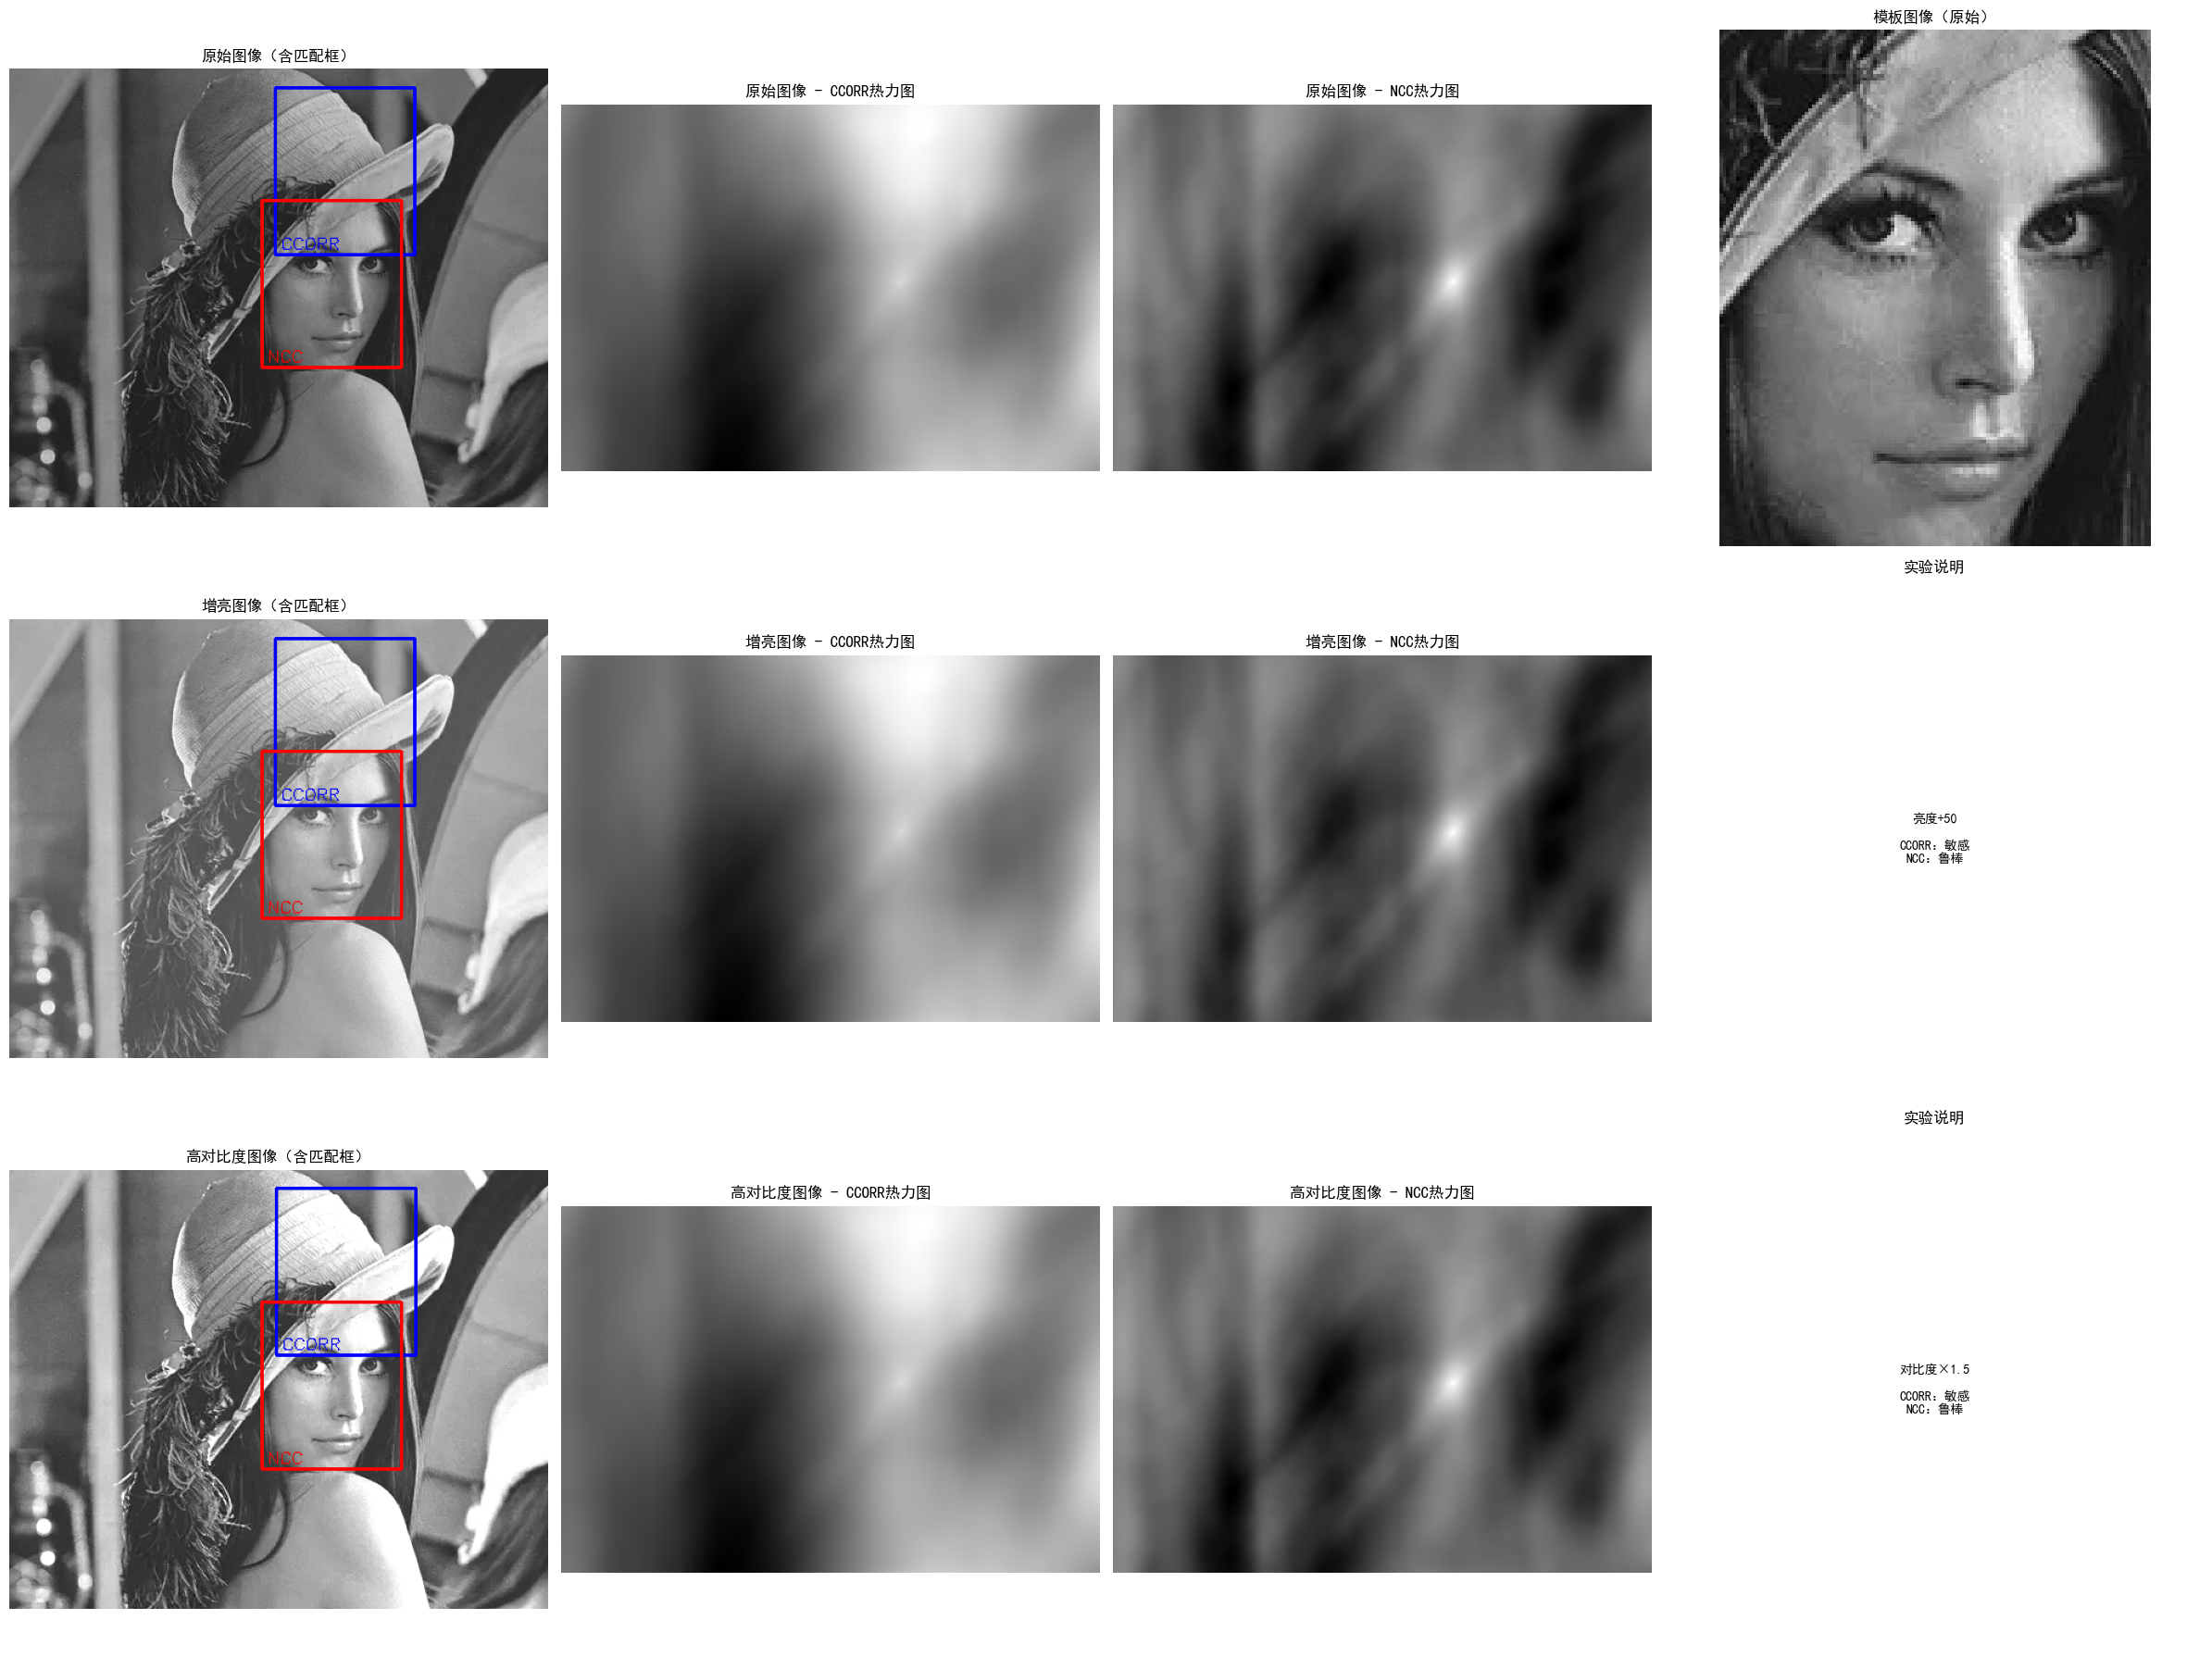

【原始图像匹配结果】
CCORR（普通相关性） 最佳位置：(240, 17) | 最大相关值：248969152.000000
NCC（归一化互相关） 最佳位置：(228, 119) | 最大相关值（[0,1]）：0.999801
【增亮图像匹配结果（亮度+50）】
CCORR（普通相关性） 最佳位置：(240, 17) | 最大相关值：343531904.000000
NCC（归一化互相关） 最佳位置：(228, 119) | 最大相关值（[0,1]）：0.991236
【高对比度图像匹配结果（对比度×1.5）】
CCORR（普通相关性） 最佳位置：(241, 16) | 最大相关值：366755904.000000
NCC（归一化互相关） 最佳位置：(228, 119) | 最大相关值（[0,1]）：0.999188


In [64]:
plt.figure(figsize=(24, 18))

# 第一行：原始图像结果
plt.subplot(3, 4, 1)
plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
plt.title(title1)
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(res_ccorr, cmap='gray')
plt.title('原始图像 - CCORR热力图')
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(res_ncc, cmap='gray')
plt.title('原始图像 - NCC热力图')
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(tpl, cmap='gray')
plt.title('模板图像（原始）')
plt.axis('off')

# 第二行：增亮图像结果
plt.subplot(3, 4, 5)
plt.imshow(cv2.cvtColor(img_bright_box, cv2.COLOR_BGR2RGB))
plt.title(title2)
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(res_ccorr_bright, cmap='gray')
plt.title('增亮图像 - CCORR热力图')
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(res_ncc_bright, cmap='gray')
plt.title('增亮图像 - NCC热力图')
plt.axis('off')

plt.subplot(3, 4, 8)
plt.text(0.5, 0.5, '亮度+50\n\nCCORR：敏感\nNCC：鲁棒', ha='center', va='center', fontsize=10)
plt.title('实验说明')
plt.axis('off')

# 第三行：高对比度图像结果
plt.subplot(3, 4, 9)
plt.imshow(cv2.cvtColor(img_contrast_box, cv2.COLOR_BGR2RGB))
plt.title(title3)
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(res_ccorr_contrast, cmap='gray')
plt.title('高对比度图像 - CCORR热力图')
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(res_ncc_contrast, cmap='gray')
plt.title('高对比度图像 - NCC热力图')
plt.axis('off')

plt.subplot(3, 4, 12)
plt.text(0.5, 0.5, '对比度×1.5\n\nCCORR：敏感\nNCC：鲁棒', ha='center', va='center', fontsize=10)
plt.title('实验说明')
plt.axis('off')

plt.tight_layout()
plt.show()

print("【原始图像匹配结果】")
print(f"CCORR（普通相关性） 最佳位置：{loc_ccorr} | 最大相关值：{val_ccorr:.6f}")
print(f"NCC（归一化互相关） 最佳位置：{loc_ncc} | 最大相关值（[0,1]）：{val_ncc:.6f}")

print("【增亮图像匹配结果（亮度+50）】")
print(f"CCORR（普通相关性） 最佳位置：{loc_ccorr_bright} | 最大相关值：{val_ccorr_bright:.6f}")
print(f"NCC（归一化互相关） 最佳位置：{loc_ncc_bright} | 最大相关值（[0,1]）：{val_ncc_bright:.6f}")

print("【高对比度图像匹配结果（对比度×1.5）】")
print(f"CCORR（普通相关性） 最佳位置：{loc_ccorr_contrast} | 最大相关值：{val_ccorr_contrast:.6f}")
print(f"NCC（归一化互相关） 最佳位置：{loc_ncc_contrast} | 最大相关值（[0,1]）：{val_ncc_contrast:.6f}")
